# **Potato Disease Project**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import numpy as np

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### **DATA PREPOCESSING**

##### **ETL**

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Potato', shuffle=True , image_size=(256,256), batch_size = 20
)

Found 2152 files belonging to 3 classes.


In [22]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

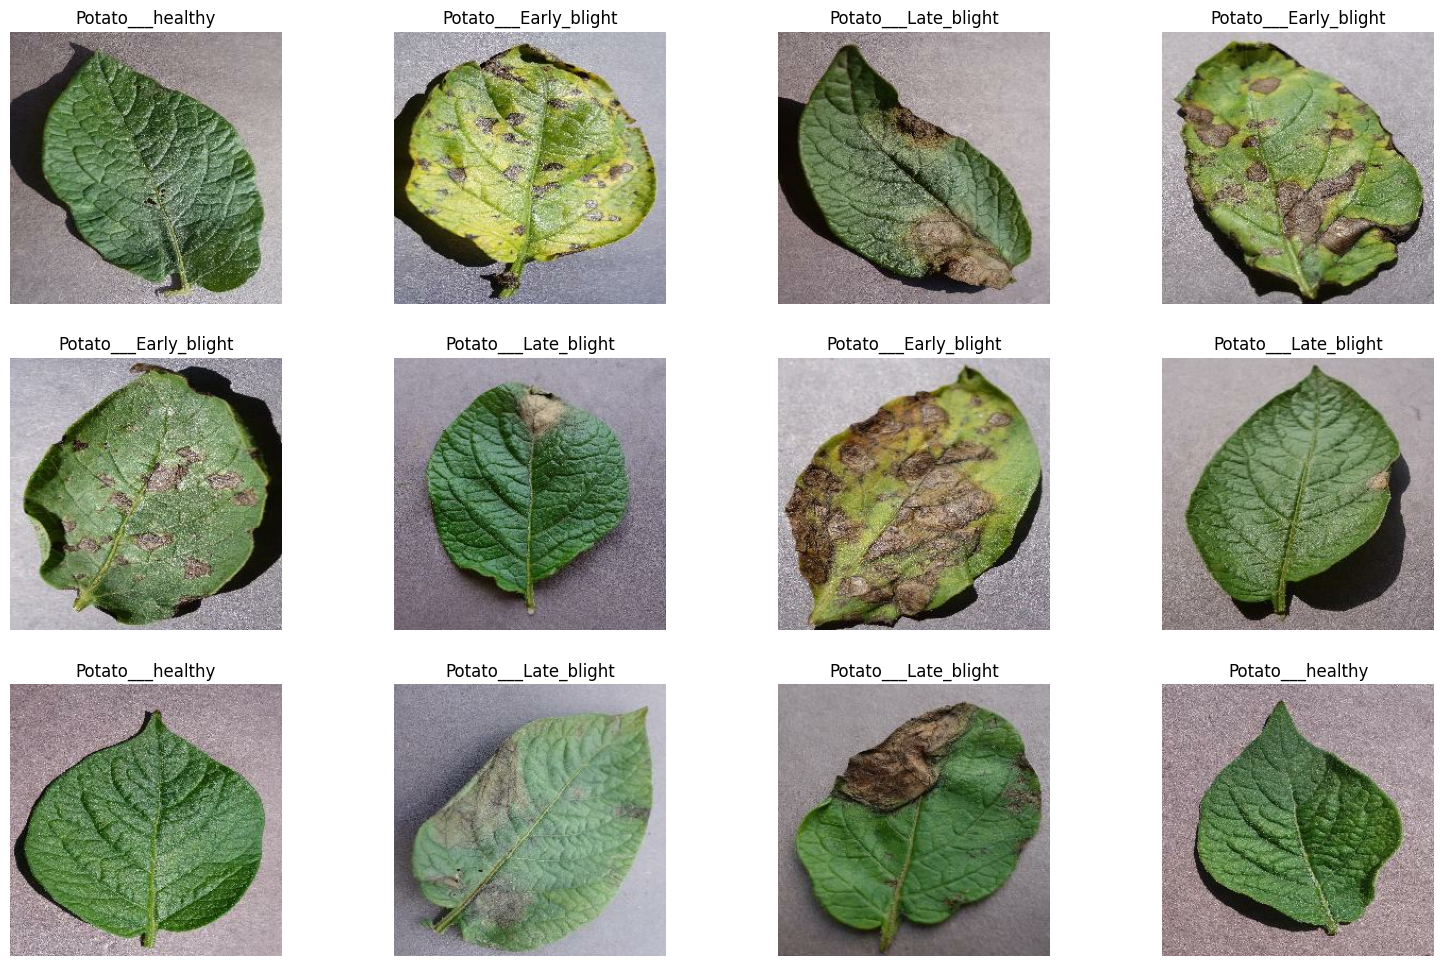

In [6]:
plt.figure(figsize=(19,12))
for image_batch, image_label in dataset.take(1):
    for x in range(12):
        ax = plt.subplot(3,4, x+1)
        plt.imshow(image_batch[x].numpy().astype('uint8'))
        plt.title(class_names[image_label[x]])
        plt.axis('off')

In [7]:
def train_test_val_split(ds, train_split=0.70, val_split=0.1, test_split=0.2, shuffle = True, shuffle_size=10000):
    ds_size = len(ds)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train = ds.take(train_size)
    val = ds.skip(train_size).take(val_size)
    test = ds.skip(train_size).skip(val_size)

    return train, test , val 

In [8]:
train , test , val = train_test_val_split(dataset, shuffle=True)

##### **OPTIMIAZTION**

In [9]:
train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255),
    tf.keras.layers.experimental.preprocessing.Resizing(255,255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')
])

### **MODEL** 

In [12]:
input_shape = (20,256,256,3)
model = tf.keras.Sequential([
    resize_rescale, data_augmentation,
    # CONVULTUION & POOLING
    tf.keras.layers.Conv2D(32, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    # NEURAL NETWORKS
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (20, 255, 255, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 255, 255, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 253, 253, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [15]:
model.fit(train, epochs=15)

Epoch 1/15
75/75 [==============================] - 337s 4s/step - loss: 0.8633 - accuracy: 0.5442
Epoch 2/15
75/75 [==============================] - 299s 4s/step - loss: 0.6640 - accuracy: 0.7225
Epoch 3/15
75/75 [==============================] - 287s 4s/step - loss: 0.5073 - accuracy: 0.7862
Epoch 4/15
75/75 [==============================] - 241s 3s/step - loss: 0.3885 - accuracy: 0.8324
Epoch 5/15
75/75 [==============================] - 185s 2s/step - loss: 0.2857 - accuracy: 0.8921
Epoch 6/15
75/75 [==============================] - 275s 4s/step - loss: 0.2467 - accuracy: 0.9048
Epoch 7/15
75/75 [==============================] - 275s 4s/step - loss: 0.2455 - accuracy: 0.9082
Epoch 8/15
75/75 [==============================] - 306s 4s/step - loss: 0.1860 - accuracy: 0.9296
Epoch 9/15
75/75 [==============================] - 234s 3s/step - loss: 0.1687 - accuracy: 0.9336
Epoch 10/15
75/75 [==============================] - 262s 3s/step - loss: 0.2065 - accuracy: 0.9336
Epoch 11/

In [18]:
model.evaluate(test)

23/23 [==============================] - 20s 833ms/step - loss: 0.0713 - accuracy: 0.9735


[0.07130297273397446, 0.9734513163566589]

Actual Label:  Potato___Early_blight
1/1 [==============================] - 1s 1s/step
Predicted Label:  Potato___Early_blight


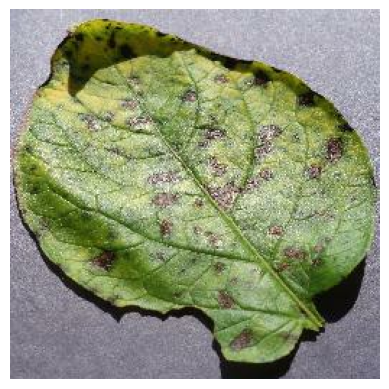

In [20]:
for image_batch, image_label in test.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')
    print('Actual Label: ',class_names[image_label[0]])

    a = model.predict(image_batch)[0]
    print('Predicted Label: ', class_names[np.argmax(a)])

In [18]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predict_class = class_names[np.argmax(predictions[0])]
    accuracy = round(100* np.max(predictions[0]),2)
    return predict_class, accuracy
    

1/1 [==============================] - 1s 1s/step


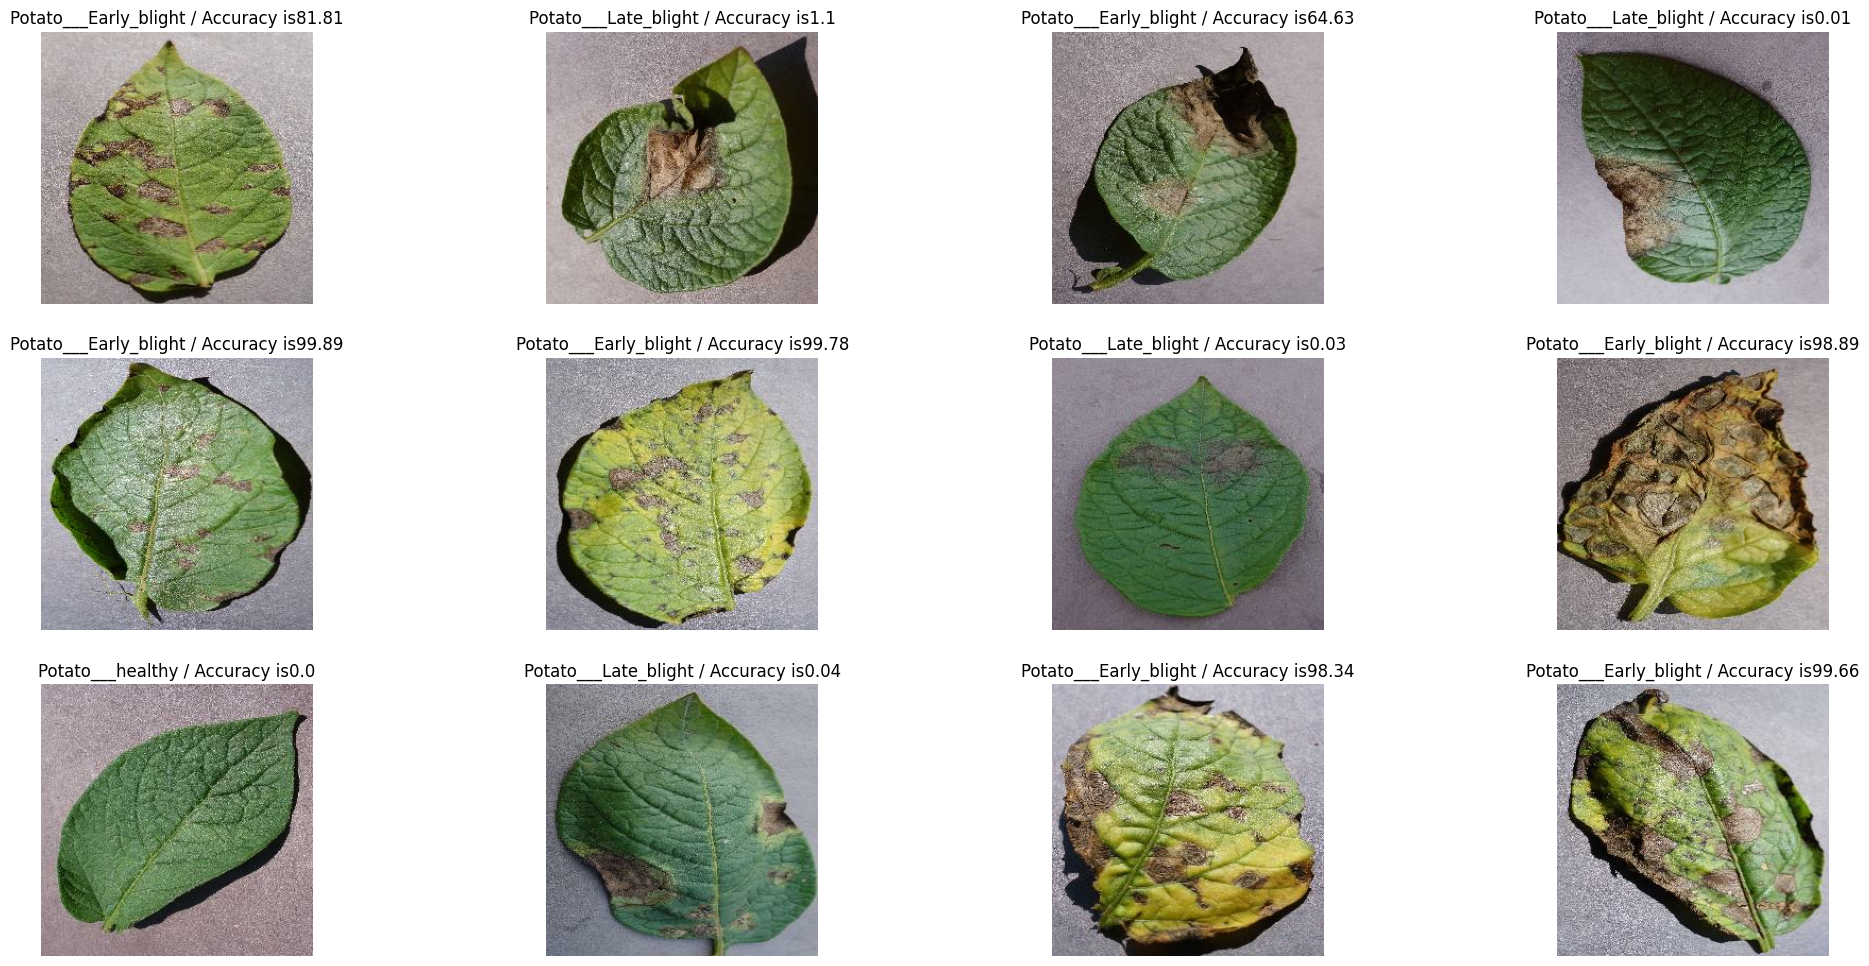

In [19]:
plt.figure(figsize=(25,12))
for image_batch, image_label in test.take(1):
    for x in range(12):
        a = model.predict(image_batch)[x]
        predict = str(class_names[np.argmax(a)])
        accuracy = 'Accuracy is' +  str(round(100* np.max(a[0]),2))
        plt.subplot(3,4, x+1)
        plt.imshow(image_batch[x].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(predict +' / '+ accuracy)

In [20]:
model_version = 1
model.save(f'/Model/{model_version}')

INFO:tensorflow:Assets written to: /Model/1\assets


INFO:tensorflow:Assets written to: /Model/1\assets
